In [1]:
%%capture
!pip install pandas
!pip install numpy
!pip install darts
!pip install matplotlib
!pip install -U "gluonts[torch]==0.11.0" "optuna~=2.10.0"
!pip install ipykernel
!pip install --upgrade nbformat
!pip install lightgbm xgboost
!pip install seaborn
!pip install distributed
!pip install datasetsforecast
!pip install darts
!pip install mlforecast
!pip install statsforecast

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta, date
import seaborn as sea

In [2]:
data = pd.read_csv('Processed_Data(Interpolated)')
data.set_index('Date')

,County,median_price,avg_value,CPI,adj_median_price,adj_avg_value
Date,,,,,,
2008-02-02,Los Angeles,450000.000000,415114.267851,212.713241,211552.415394,195152.057841
2008-02-09,Los Angeles,460000.000000,415114.267851,212.896931,216066.994374,194983.678644
2008-02-16,Los Angeles,474000.000000,415114.267851,213.080621,222451.013361,194815.589756
2008-02-23,Los Angeles,482000.000000,415114.267851,213.264310,226010.624666,194647.790425
2008-03-01,Los Angeles,460000.000000,409234.159417,213.448000,215509.163824,191725.459792
...,...,...,...,...,...,...
2024-01-06,Merced,701285.714286,289806.009213,309.905806,226289.956395,93514.223735
2024-01-13,Merced,720142.857143,289806.009213,310.214935,232143.193241,93421.036857
2024-01-20,Merced,696377.142857,289806.009213,310.524065,224258.671850,93328.035515


In [99]:
Counties_median = data[['Date','County','adj_median_price']]
Counties_value = data[['Date','County','adj_avg_value']]

In [103]:
median_train = Counties_median[Counties_median['Date'] < '2023-01-06']
median_test = Counties_median[Counties_median['Date'] >= '2023-01-06']

median_train = median_train.pivot_table(index='Date',columns='County',values='adj_median_price')
median_test = median_test.pivot_table(index='Date',columns='County',values='adj_median_price')

value_train = Counties_value[Counties_median['Date'] < '2023-01-06']
value_test = Counties_value[Counties_median['Date'] >= '2023-01-06']

value_train = value_train.pivot_table(index='Date',columns='County',values='adj_avg_value')
value_test = value_test.pivot_table(index='Date',columns='County',values='adj_avg_value')

CPI_train = data[['Date','CPI']]
CPI_train = CPI_train[CPI_train['Date'] < '2023-01-06']
CPI_train = CPI_train.pivot_table(index='Date',values='CPI')

CPI_test = data[['Date','CPI']]
CPI_test = CPI_test[CPI_test['Date'] >= '2023-01-06']
CPI_test = CPI_test.pivot_table(index='Date',values='CPI')

median_train = median_train.merge(CPI_train,on='Date')
value_train = value_train.merge(CPI_train,on='Date')

median_test = median_test.merge(CPI_test,on='Date')
value_test = value_test.merge(CPI_test,on='Date')

CPI = data[['Date','CPI']]
CPI = CPI.pivot_table(index='Date',values='CPI')

,Date,CPI
0,2008-02-02,212.713241
1,2008-02-09,212.896931
2,2008-02-16,213.080621
3,2008-02-23,213.264310
4,2008-03-01,213.448000
...,...,...
831,2024-01-06,309.905806
832,2024-01-13,310.214935
833,2024-01-20,310.524065
834,2024-01-27,310.833194


In [104]:
from darts import TimeSeries

median_train = median_train.reset_index()
median_train = TimeSeries.from_dataframe(median_train, time_col='Date', value_cols = ['Fresno', 'Los Angeles', 'Merced', 'Riverside', 'Sacramento', 
              'San Diego', 'San Francisco', 'San Luis Obispo','CPI'])

median_test = median_test.reset_index()
median_test = TimeSeries.from_dataframe(median_test, time_col='Date', value_cols = ['Fresno', 'Los Angeles', 'Merced', 'Riverside', 'Sacramento',
       'San Diego', 'San Francisco', 'San Luis Obispo','CPI'])

CPI = CPI.reset_index()
CPI = TimeSeries.from_dataframe(CPI, time_col='Date', value_cols = ['CPI'])

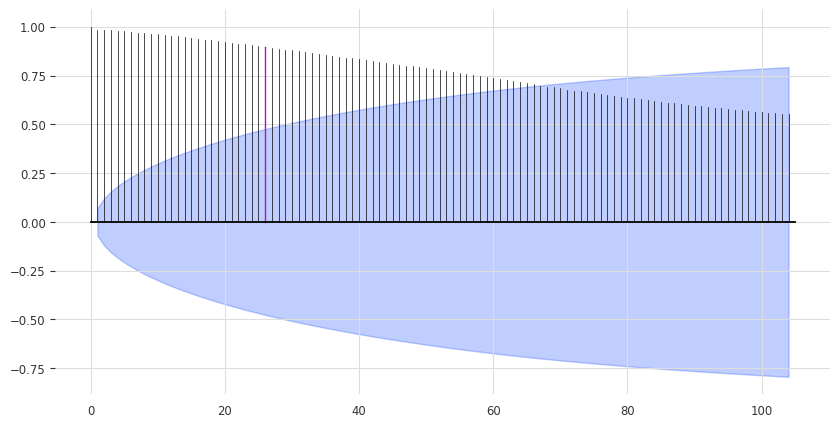

In [18]:
from darts.utils.statistics import plot_acf, check_seasonality

plot_acf(median_train['San Diego'],m=26,alpha=0.05,max_lag=104)
for m in range(2, 104):
    is_seasonal, period = check_seasonality(median_train['San Diego'], m=m, alpha=0.05,max_lag=104)
    if is_seasonal:
        print("There is seasonality of order {}.".format(period))

<Axes: xlabel='Date'>

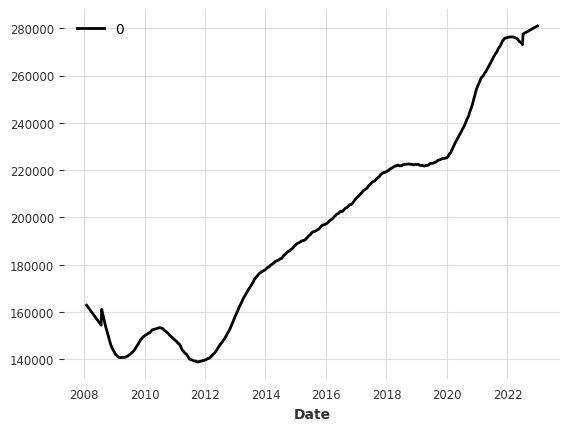

In [24]:
from darts.utils.statistics import extract_trend_and_seasonality
from darts.utils.utils import ModelMode

extract_trend_and_seasonality(median_train['San Diego'],model= ModelMode.MULTIPLICATIVE)[0].plot()

<Axes: xlabel='Date'>

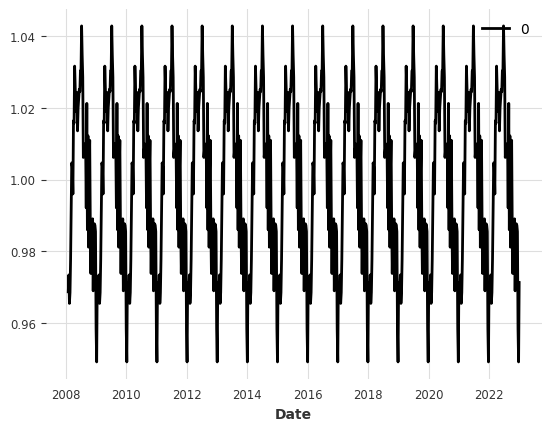

In [25]:
extract_trend_and_seasonality(median_train['San Diego'],model= ModelMode.MULTIPLICATIVE)[1].plot()

In [89]:
from darts.models import RegressionModel, RandomForest
from sklearn.linear_model import BayesianRidge

model=RandomForest(lags=52,lags_past_covariates=26,output_chunk_length=52)

model.fit(median_train['San Diego'],past_covariates=median_train['CPI'])

preds = model.predict(52)



<Axes: xlabel='Date'>

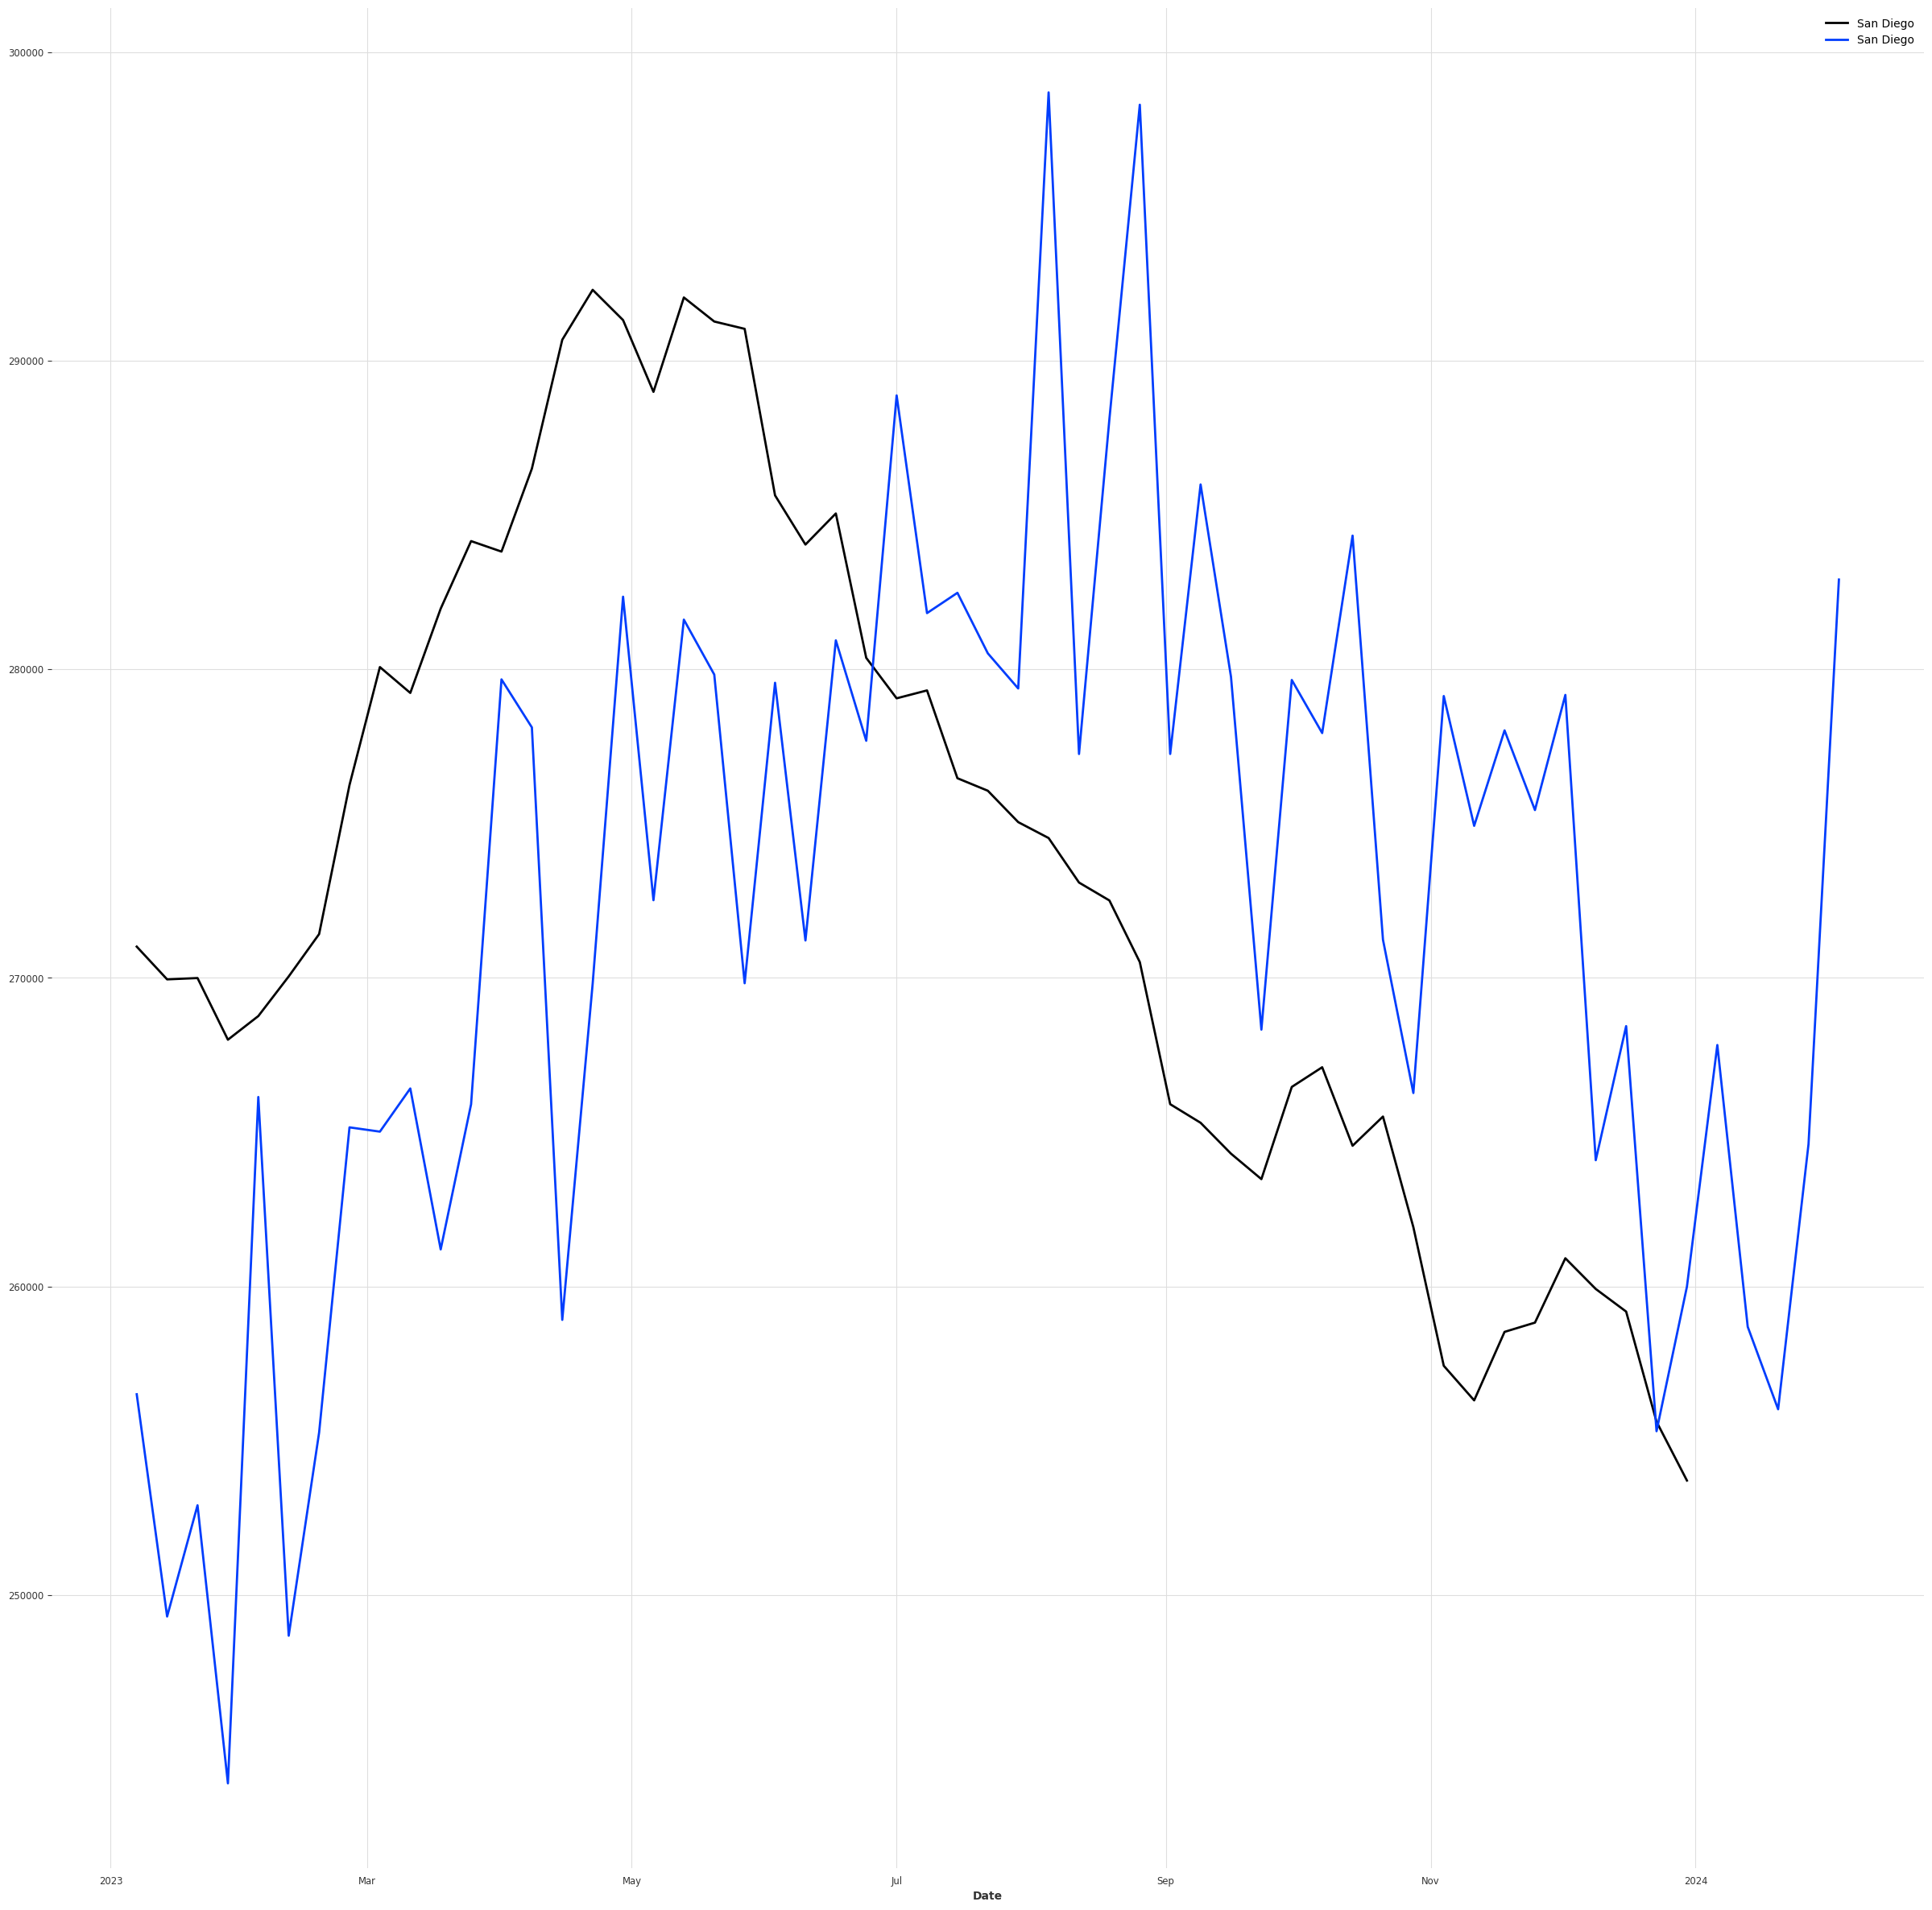

In [90]:
plt.figure(figsize=(30,30))
preds.plot()
median_test['San Diego'].plot()

In [166]:
from darts.models import XGBModel

model2 = XGBModel(lags=52,lags_past_covariates=4,output_chunk_length=60,
                  random_state=42,lags_future_covariates=[0,4,8,12,16],
                  add_encoders={'cyclic': {'future' : ['month']}})

model2.fit(median_train['San Diego'],past_covariates=median_train['CPI'],future_covariates=CPI)

preds = model2.predict(60)



<Axes: xlabel='Date'>

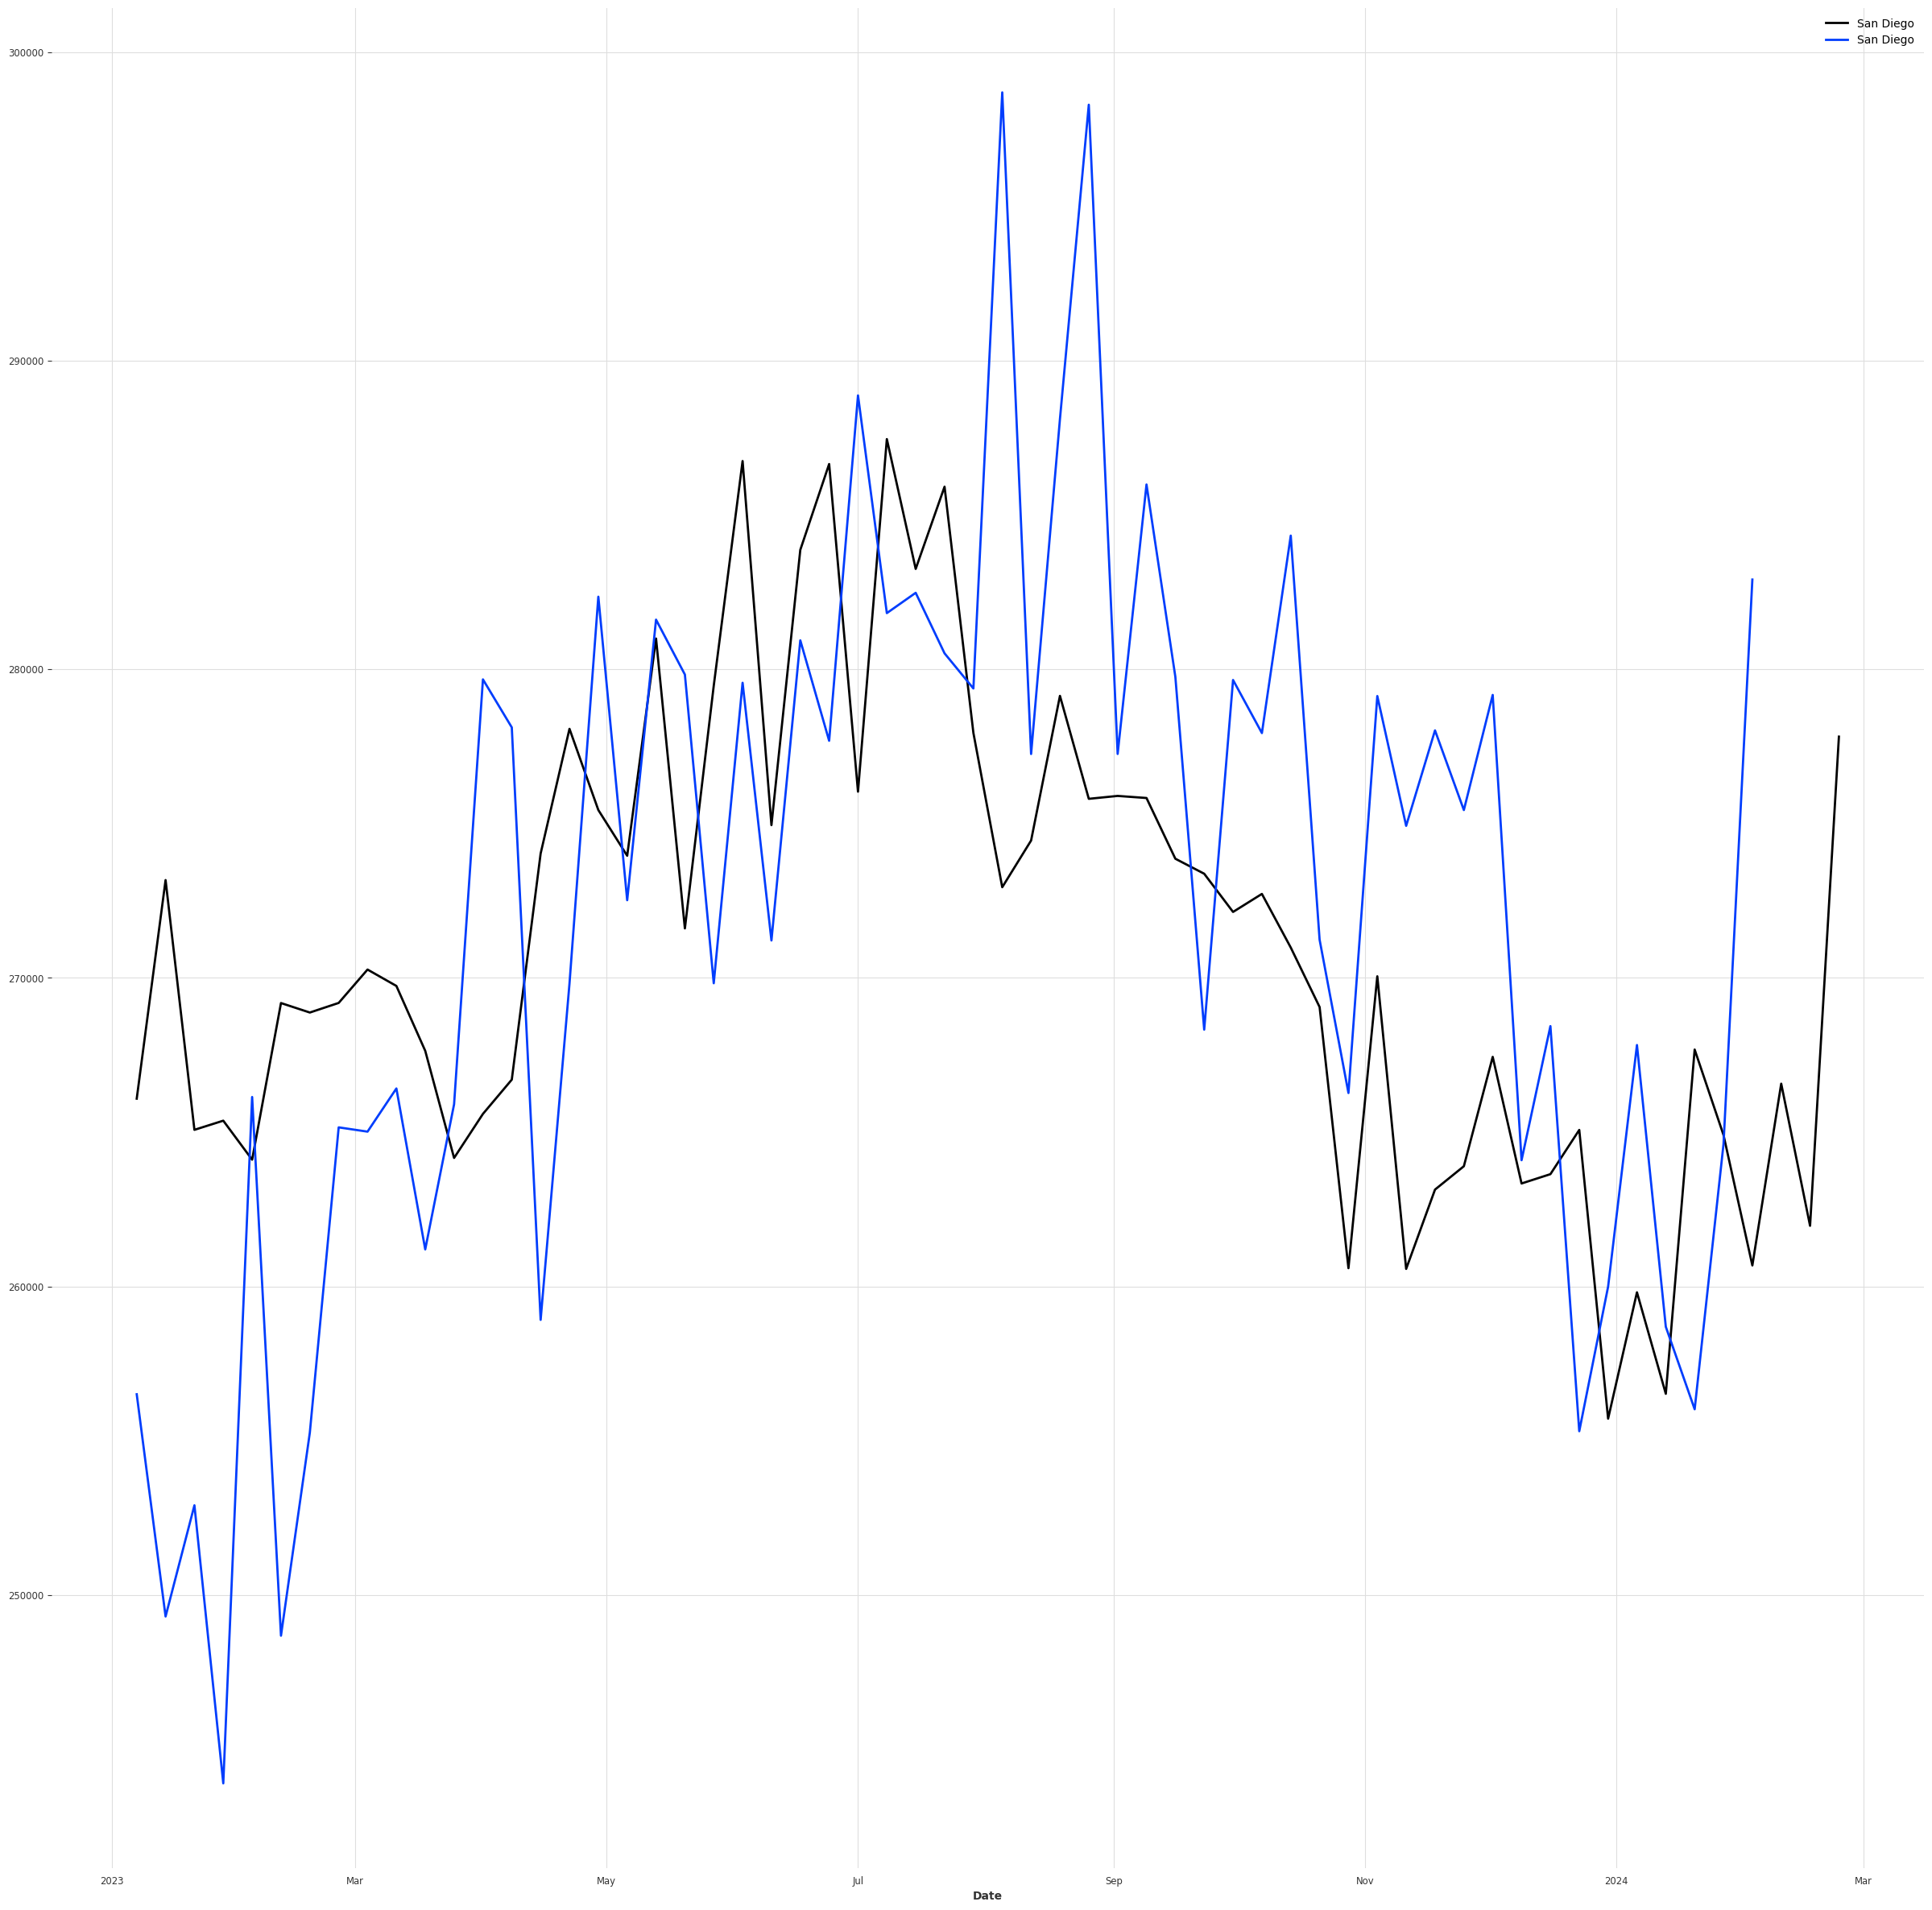

In [167]:
plt.figure(figsize=(30,30))
preds.plot()
median_test['San Diego'].plot()

In [111]:
CPI.last_value()

311.054